In [2]:
import os
import json
from collections import defaultdict, namedtuple
import pandas as pd
import matplotlib as mpl
from matplotlib import pyplot as plt
from matplotlib import gridspec

import matplotlib.patheffects as path_effects

import re,glob,os,json
import numpy as np
import pandas as pd

# Define the namedtuple for Member
Member = namedtuple('Member', ['contig', 'length', 'percent_id', 'percent_id_sign', 'sample', 'coverage'])

# Define base path
base_path = '/Volumes/aine_store/SENZOR_project/SPlited_SENSOR_porject/IDseq/Combined_SENZOR_results/'

# Function to parse CD-HIT cluster rows
def parse_cdhit_row(row):
    parts = row.strip().split()
    if '*' in row:
        index, length, name, percent_id = parts
        percent_id_sign, percent_id = '0', 100
    else:
        if len(parts) < 5:
            # Handle cases with missing percent_id
            index, length, name, _, percent_id = parts + ['0']
        else:
            index, length, name, _, percent_id = parts
        if '/' in percent_id:
            percent_id_sign, percent_id = percent_id.strip('%').split('/')
            percent_id = float(percent_id)
        else:
            percent_id_sign, percent_id = '0', 100
    try:
        length = int(length.strip(',nt'))
    except ValueError:
        length = 0  # Handle malformed length
    name = name.strip('>').strip('.').strip().lower()  # Standardize contig name
    try:
        sample, contig = name.split('~')
    except ValueError:
        # Handle cases where sample and contig are not separated by '~'
        sample, contig = 'UNKNOWN_SAMPLE', name
    try:
        coverage = float(contig.split('_')[-1])
    except (ValueError, IndexError):
        coverage = 0.0  # Handle malformed coverage
    return Member(contig=contig, sample=sample, length=length,
                  percent_id=percent_id, percent_id_sign=percent_id_sign, coverage=coverage)

# Build clusters dictionary
clusters = defaultdict(list)
cluster_file = os.path.join(base_path, 'Combined_filtered_500_SENZOR_clsuter.clstr')
with open(cluster_file, 'r') as file:
    for line in file:
        if line.startswith('>Cluster'):
            cluster_id = line.split()[-1]
        else:
            member = parse_cdhit_row(line)
            if 'water' in member.sample.lower():
                continue
            clusters[cluster_id].append(member)

# Build contig_info dictionary using pandas for robustness
contig_info = {}
contig_calls_file = os.path.join(base_path, 'contig_calls_decontam.tsv')
try:
    contig_calls_df = pd.read_csv(contig_calls_file, sep='\t')
except Exception as e:
    print(f"Error reading {contig_calls_file}: {e}")
    exit(1)

# Standardize sample and contig names
contig_calls_df['sample'] = contig_calls_df['sample'].str.strip().str.upper()
contig_calls_df['contig_name'] = contig_calls_df['contig_name'].str.strip().str.lower()

# Convert read_count to numeric, coercing errors to NaN and filling with 0
contig_calls_df['read_count'] = pd.to_numeric(contig_calls_df['read_count'], errors='coerce').fillna(0).astype(int)

# Build contig_info dictionary
for _, row in contig_calls_df.iterrows():
    sample = row['sample']
    contig_name = row['contig_name']
    read_count = row['read_count']
    
    if sample not in contig_info:
        contig_info[sample] = {}
    
    # Store all relevant fields
    contig_info[sample][contig_name] = row.to_dict()

# Calculate total_reads per sample
total_reads = {}
for sample in contig_info:
    # Sum read_count across all contigs in the sample
    total_reads[sample] = contig_calls_df[contig_calls_df['sample'] == sample]['read_count'].sum()

metadata={}
for line in open(os.path.join(base_path,'Metada_annotated.csv'),'r'):
    l=line.strip('\r\n').split(',')
    if 'NewIDseqName' in l[0]:
        header=l
    else:
        metadata[l[0]]={header[i]:l[i].strip(' ') for i in range(len(l))} ## load metadata

print(f"Total reads across all samples: {sum(total_reads.values())}")

/var/folders/xt/vz8fznds4hdbfcxyds95mtp00000gp/T/ipykernel_15286/1155638709.py:72: DtypeWarning: Columns (4,16,19) have mixed types. Specify dtype option on import or set low_memory=False.
  contig_calls_df = pd.read_csv(contig_calls_file, sep='\t')


Total reads across all samples: 133103889


In [10]:
# ------------------------------------------------------
# 1) BUILD A HELPER MAP FOR CONTIG LOOKUP
# ------------------------------------------------------
# This map will relate (sample, "node_...") -> "full_key_in_contig_info".
# For example, it turns:
#   sample="AIAMACAT001_S69_657769"
#   contig key="aiamacat001_s69_657769_node_1002_length_431_cov_10.635593"
# into a mapping: "node_1002_length_431_cov_10.635593" -> "aiamacat001_s69_657769_node_1002_length_431_cov_10.635593"

contig_map = {}
for s in contig_info:
    s_upper = s.upper()  # match the "standardized_sample"
    contig_map[s_upper] = {}
    for full_key in contig_info[s].keys():
        # Example full_key: "aiamacat001_s69_657769_node_1002_length_431_cov_10.635593"
        # Convert to lowercase for consistency
        full_key_lc = full_key.lower()
        # Attempt to find the "node_" substring
        pos = full_key_lc.find("node_")
        if pos != -1:
            short_key = full_key_lc[pos:]  # e.g. "node_1002_length_431_cov_10.635593"
            contig_map[s_upper][short_key] = full_key

print("\nBuilt contig_map for node-based lookups. Example:")
some_sample = next(iter(contig_map))
print(f"Sample: {some_sample}, Map has {len(contig_map[some_sample])} contig entries")


# ------------------------------------------------------
# 2) ORIGINAL CODE (with minimal changes to unify contig lookup)
# ------------------------------------------------------
print("\n--- Diagnostic: Sample Contig Read Counts ---")
for sample in list(contig_info.keys())[:3]:  # Inspect first 3 samples
    for contig in list(contig_info[sample].keys())[:3]:  # Inspect first 3 contigs per sample
        read_count = contig_info[sample][contig].get('read_count', 0)
        print(f"Sample: {sample}, Contig: {contig}, Read Count: {read_count}")

# Load virus data
virus_data_file = os.path.join(base_path, 'virus_RNA.json')
try:
    with open(virus_data_file, 'r') as in_json:
        virus = json.load(in_json)
except Exception as e:
    print(f"Error reading {virus_data_file}: {e}")
    exit(1)

# Identify segmented viruses
segmented_RdRps = [pol for pol in virus if len(virus[pol].get('segments', {})) > 0]
print(f"Total segmented RdRps: {len(segmented_RdRps)}")

# Load metadata
metadata = {}
metadata_file = os.path.join(base_path, 'Metada_annotated.csv')
try:
    metadata_df = pd.read_csv(metadata_file)
except Exception as e:
    print(f"Error reading {metadata_file}: {e}")
    exit(1)

# Build metadata dictionary
for _, row in metadata_df.iterrows():
    sample_id = row['NewIDseqName']
    metadata[sample_id] = row.to_dict()

# Define helper functions
def species(sample):
    return f"{metadata.get(sample, {}).get('ska_genus', 'Unknown')} {metadata.get(sample, {}).get('ska_species', 'Unknown')}"

def sample_loc(sample):
    return metadata.get(sample, {}).get('collected_by', 'Unknown')

# Define order and sorting functions
order = [
    'RdRp','hypothetical','genome','GP','RdRp_L','RNA','RNA3','RdRp_NS',
    'RNA2','RdRp_SP','NSP','RNA4','RNA1','RdRp_VP','HA','RdRp_3D','Capsid','DNA'
]

print("Order list:", order)

def sort_RdRps(k):
    return (virus[k].get('family', ''), -len(clusters.get(k, [])))

def sort_segs(k):
    if k in order:
        return (0, -order.index(k), k)
    else:
        return (1, k, k)

subset_order = [5, 40, 36, 47, 49, 71, 72, 105, 107, 106, 109, 108,110, 119]
subset_row_names = {pol: [] for pol in subset_order}

# Initialize matrices and tracking lists
read_matrix = {}
length_matrix = {}
sample_order_list = []
row_names = []
did_not_blast = []

# Diagnostic: List of all samples in contig_info
print(f"\nTotal samples in contig_info: {len(contig_info)}")
for sample in list(contig_info.keys())[:5]:  # Display first 5 samples
    print(f"Sample: {sample}, Number of contigs: {len(contig_info[sample])}")
    for contig in list(contig_info[sample].keys())[:5]:
        print(f"  Contig: {contig}")

# Process each segmented RdRp
for p, pol in enumerate(sorted(segmented_RdRps, key=sort_RdRps), 1):
    print(f"\nProcessing RdRp {p}/{len(segmented_RdRps)}: {pol}")
    family = virus[pol].get('family', 'Unknown').strip()
    
    # Extract virus name
    if virus[pol].get('name', '').strip().lower() != 'TBD':
        name = virus[pol].get('name', 'Unknown').strip()
    else:
        name = virus[pol].get('name', 'Unknown').strip()
    
    # Remove trailing "viridae"
    family_short = family.replace('viridae', '').strip()
    
    samples = virus[pol].get('samples', [])
    print(f"  Family: {family}, Name: {name}")
    
    # Standardize sample names when adding to sample_order_list
    for sample in sorted(samples, key=lambda k: (sample_loc(k), species(k), -total_reads.get(k, 0))):
        standardized_sample = sample.strip().upper()
        if standardized_sample not in sample_order_list:
            sample_order_list.append(standardized_sample)
            print(f"  Added sample to order: {standardized_sample}")
            
            # Initialize the new sample in all existing rows
            for row in read_matrix:
                read_matrix[row][standardized_sample] = 0
                length_matrix[row][standardized_sample] = 0
    
    # Sort segments
    for seg in sorted(virus[pol].get('segments', {}), key=sort_segs):
        print(f"  Processing segment: {seg}")
        segment_clusters = list(map(str, virus[pol]['segments'][seg].get('clusters', [])))
        parts = seg.split('_')
        if 'RdRp' in seg and len(parts) > 1:
            s = parts[1]
        else:
            s = seg

        row_name = f"{s} {name} ({family_short})"
        row_names.append(row_name)
        if int(pol) in subset_row_names:
            subset_row_names[int(pol)].append(row_name)
    
        if row_name not in read_matrix:
            # Initialize all samples with 0
            read_matrix[row_name] = {sample: 0 for sample in sample_order_list}
            length_matrix[row_name] = {sample: 0 for sample in sample_order_list}
            print(f"    Initialized matrices for row: {row_name}")
    
        B = []  # Track whether contigs have blasted
        for clust in segment_clusters:
            print(f"    Processing cluster: {clust}")
            members = clusters.get(clust, [])
            print(f"      Number of members in cluster: {len(members)}")
            for m in members:
                # Standardize sample and contig names
                standardized_sample = m.sample.strip().upper()
                standardized_contig = m.contig.strip().lower()
    
                # Check if the sample is already in sample_order_list
                if standardized_sample not in sample_order_list:
                    sample_order_list.append(standardized_sample)
                    print(f"    Added sample to order: {standardized_sample}")
                    
                    # Initialize the new sample in all existing rows
                    for row in read_matrix:
                        read_matrix[row][standardized_sample] = 0
                        length_matrix[row][standardized_sample] = 0
    
                # ------------------------------------------------------
                # *** HERE IS THE CORE FIX: use contig_map to unify keys ***
                # ------------------------------------------------------
                if standardized_sample in contig_map:
                    if standardized_contig in contig_map[standardized_sample]:
                        # Retrieve the actual "full" key from contig_info
                        full_contig_name = contig_map[standardized_sample][standardized_contig]
                        
                        # Check if that full key is actually in contig_info
                        if full_contig_name in contig_info[standardized_sample]:
                            blasted = contig_info[standardized_sample][full_contig_name].get('blasted', 'False') == 'True'
                            B.append(blasted)
                            
                            length_matrix[row_name][standardized_sample] += m.length
                            read_count = contig_info[standardized_sample][full_contig_name].get('read_count', 0)
    
                            # Prevent division by zero, compute RPM
                            if total_reads.get(standardized_sample, 0) > 0:
                                read_fraction = (int(read_count) / total_reads[standardized_sample]) * 1e6
                            else:
                                read_fraction = 0
                                print(f"    Warning: Total reads for sample '{standardized_sample}' is zero.")
                            read_matrix[row_name][standardized_sample] += read_fraction
    
                            print(f"        Sample: {standardized_sample}, Contig: {full_contig_name}, "
                                  f"Read Count: {read_count}, Total Reads: {total_reads[standardized_sample]}, "
                                  f"RPM: {read_fraction}")
                        else:
                            print(f"        Full key '{full_contig_name}' not found in contig_info[{standardized_sample}]")
                    else:
                        print(f"        Contig '{standardized_contig}' not in contig_map for '{standardized_sample}'")
                else:
                    print(f"        Sample '{standardized_sample}' not found in contig_map")

        # If some contigs were processed, check the blast ratio
        if B:
            if B.count(False) > len(B) / 2:
                did_not_blast.append(row_name)
                print(f"    More than half contigs did not blast for row: {row_name}")
        else:
            print(f"    No contigs processed for row: {row_name}")

# Diagnostic: Check for samples with zero total reads
zero_total_reads = [sample for sample, reads in total_reads.items() if reads == 0]
if zero_total_reads:
    print(f"\nWarning: The following samples have zero total reads and will have RPM set to 0:")
    for sample in zero_total_reads:
        print(f"  - {sample}")
else:
    print("\nAll samples have non-zero total reads.")

# Convert to pandas DataFrames
rmatrix = pd.DataFrame(read_matrix, index=sample_order_list)
lmatrix = pd.DataFrame(length_matrix, index=sample_order_list)

# Fill NaN values with 0 to prevent issues in analysis
rmatrix = rmatrix.fillna(0)
lmatrix = lmatrix.fillna(0)

# Display RPM min and max
rpm_min = rmatrix.min().min() if not rmatrix.empty else None
rpm_max = rmatrix.max().max() if not rmatrix.empty else None
print(f"\nRPM minmax: {rpm_min} {rpm_max}")

# Diagnostic: Verify RPM Calculations
print("\n--- Diagnostic: Verify RPM Calculations ---")
for sample in list(rmatrix.index)[:3]:  # Inspect first 3 samples
    for row in rmatrix.columns[:3]:  # Inspect first 3 rows per sample
        rpm_value = rmatrix.loc[sample, row]
        print(f"Sample: {sample}, Row: {row}, RPM: {rpm_value}")

# Optional: Display a subset of the matrices for verification
print("\nSample of RPM matrix:")
print(rmatrix.head())

print("\nSample of Length matrix:")
print(lmatrix.head())


Built contig_map for node-based lookups. Example:
Sample: AIAMAAGR001_LIV_S46_662105, Map has 41 contig entries

--- Diagnostic: Sample Contig Read Counts ---
Sample: AIAMAAGR001_LIV_S46_662105, Contig: aiamaagr001_liv_s46_662105_node_1021_length_477_cov_1.855000, Read Count: 13
Sample: AIAMAAGR001_LIV_S46_662105, Contig: aiamaagr001_liv_s46_662105_node_1095_length_467_cov_4.743590, Read Count: 35
Sample: AIAMAAGR001_LIV_S46_662105, Contig: aiamaagr001_liv_s46_662105_node_1468_length_429_cov_2.335227, Read Count: 94
Sample: AIAMACAT001_S69_657769, Contig: aiamacat001_s69_657769_node_1000_length_432_cov_0.833803, Read Count: 4
Sample: AIAMACAT001_S69_657769, Contig: aiamacat001_s69_657769_node_1002_length_431_cov_10.635593, Read Count: 100
Sample: AIAMACAT001_S69_657769, Contig: aiamacat001_s69_657769_node_1003_length_431_cov_4.042373, Read Count: 37
Sample: AIAMADOG001_S40_657732, Contig: aiamadog001_s40_657732_node_10000_length_281_cov_1.308824, Read Count: 6
Sample: AIAMADOG001_S40_

Total reads across all samples: 133103889


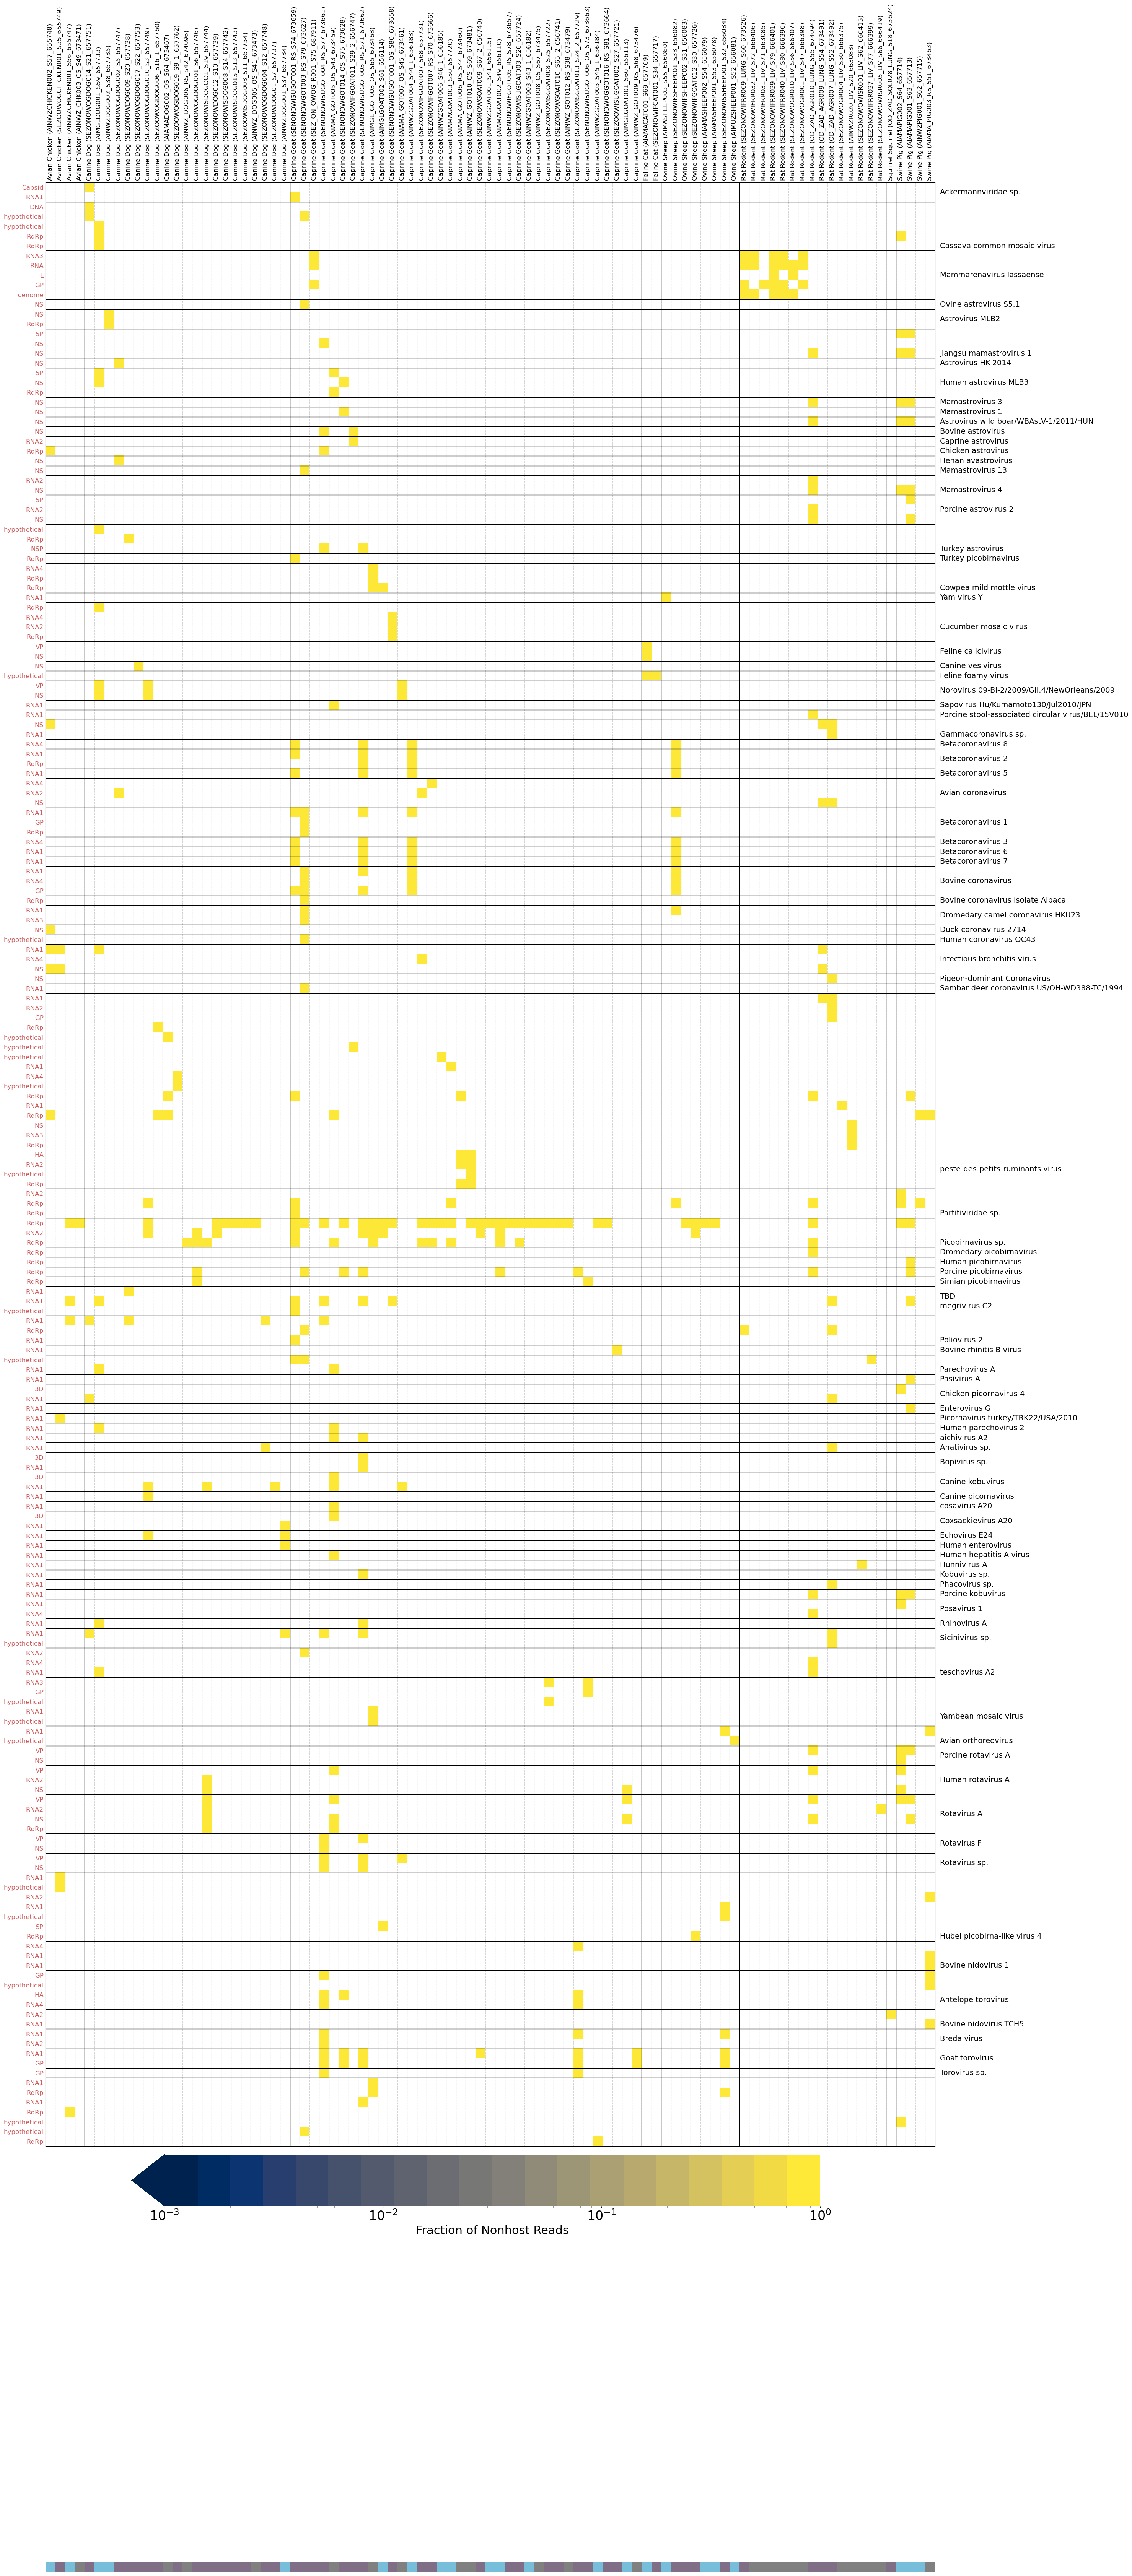

In [12]:
import textwrap
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import gridspec

# Define your sample_colour dictionary
sample_colour = {
    'Ondo': (0.49803923567136127, 0.43267975250879925, 0.52287583549817396),  # purple
    'Ebonyi': (0.4666666666666667, 0.7450980392156863, 0.8588235294117647),  # light blue
    'NA': '#C0C0C0'
}

print(f"Total reads across all samples: {sum(total_reads.values())}")

# Define a helper function to extract sample name
def extract_sample_name(label_text):
    if ' (' in label_text and label_text.endswith(')'):
        return label_text.split(' (')[1].rstrip(')')
    else:
        return label_text  # Fallback in case of unexpected format

# Subsetting and showing variables
subsetting = False  # Change to True if subsetting
showing = 'reads'    # 'reads' or 'length'

if showing == 'reads':
    matrix = rmatrix
    norm = mpl.colors.LogNorm(vmin=0.001, vmax=1.0)
    extend = 'min'
elif showing == 'length':
    matrix = lmatrix
    norm = mpl.colors.Normalize(vmin=500, vmax=2500)
    extend = 'both'

if subsetting:
    rows = sum(subset_row_names.values(), [])
    subset_species_order = {
        'feline Cat': 0, 
        'Canine Dog': 1, 
        'Caprine Goat': 2,
        "Saurian Lizard": 3,
        "Ovine Sheep": 4,
        "Avian Chicken": 5,
        "Swine Pig": 6
    }

    matrix = matrix[rows].reindex(
        sorted(
            sample_order, 
            key=lambda k: (
                subset_species_order.get(species(k), np.inf),
                sample_loc(k) != 'WVAL'
            )
        )
    ).dropna(how='all')  # Reindex to Orthomyxos+Bunya, sort by species and location, drop rows/columns that are all NaN
else:
    matrix = matrix.reindex(sorted(matrix.index, key=species))

base = 60 if subsetting else 30

fig = plt.figure(figsize=(base, 1 + base * (matrix.shape[1] / matrix.shape[0])), facecolor='w') 
gs = gridspec.GridSpec(1, 1, wspace=0.05, hspace=0.0)

ax = plt.subplot(gs[0], facecolor='w')  # New subplot

def cmap_discretize(cmap, N):
    """Return a discrete colormap from the continuous colormap cmap.
    
        cmap: colormap instance, eg. cm.jet. 
        N: number of colors.
    """
    if isinstance(cmap, str):
        cmap = plt.get_cmap(cmap)
    colors_i = np.concatenate((np.linspace(0, 1., N), (0., 0., 0., 0.)))
    colors_rgba = cmap(colors_i)
    indices = np.linspace(0, 1., N+1)
    cdict = {}
    for ki, key in enumerate(('red', 'green', 'blue')):
        cdict[key] = [(indices[i], colors_rgba[i-1, ki], colors_rgba[i, ki]) for i in range(N+1)]
    # Return colormap object.
    return mpl.colors.LinearSegmentedColormap(cmap.name + "_%d" % N, cdict, 1024)

cmap = cmap_discretize(mpl.cm.cividis, 20)
ax.matshow(matrix.T, cmap=cmap, norm=norm, zorder=1)

# Set X and Y ticks
ax.set_xticks(range(len(matrix.index)))
ax.set_yticks(range(len(matrix.columns)))

# **Set X-axis labels based on sample names**
ax.set_xticklabels(['%s (%s)' % (species(s), s) for s in matrix.index], rotation=90, size=12)
ax.set_yticklabels(matrix.columns, size=14)

# Highlight rows that did not blast
for ticklabel in ax.get_yticklabels():
    if ticklabel.get_text() in did_not_blast:
        ticklabel.set_color('indianred')
        ticklabel.set_fontweight(500)

if not subsetting:
    for t, ticklabel in enumerate(ax.get_xticklabels()):
        label_text = ticklabel.get_text()
        sample_name = extract_sample_name(label_text)
        loc = sample_loc(sample_name)
        
        # Map location to color
        colour = sample_colour.get(loc, 'grey')  # Default to 'grey' if location not found
        
        # Add colored rectangle above the x-axis
        ax.add_patch(plt.Rectangle(
            (t - 0.5, len(row_names) + 0.1), 
            1, 
            1,
            facecolor=colour,
            edgecolor='none',
            zorder=100,
            clip_on=False
        ))
        
        # Optional: Add a legend or label
        if t == len(ax.get_xticklabels()) + 1:
            ax.text(
                t + 0.7, 
                len(row_names) + 0.9, 
                'Sample Location',
                ha='left',
                va='center',
                size=20,
                clip_on=False
            )

modify_name = lambda k: ' '.join(k.get_text().split(' ')[1:-1])
virus_names = [modify_name(t) for t in ax.get_yticklabels()]
virus_coords = {v: [i for i in range(len(virus_names)) if virus_names[i] == v] for v in set(virus_names)}

lw = 2 if subsetting else 1
textsize = 28 if subsetting else 14
for v in virus_coords:
    w = v
    if len(v) > 10 and len(matrix) < 50:
        w = '\n'.join(textwrap.wrap(v, 12))
    ax.text(
        len(matrix.index), 
        np.mean(virus_coords[v]), 
        w,
        size=textsize,
        rotation=0,
        va='center',
        ha='left'
    )
    ax.axhline(max(virus_coords[v]) + 0.5, lw=lw, color='k')  # Add horizontal line

counter = 0
for s in range(len(matrix.index)):
    if s == len(matrix.index) - 1:
        if subsetting:
            ax.text(
                s - counter / 2 + 0.5,
                -0.8,
                species(matrix.index[s]),
                size=28,
                rotation=0,
                va='bottom',
                ha='center'
            )
    elif species(matrix.index[s]) != species(matrix.index[s + 1]):
        if subsetting:
            ax.text(
                s - counter / 2 + 0.5,
                -0.8,
                species(matrix.index[s]),
                size=28,
                rotation=0,
                va='bottom',
                ha='center'
            )
        ax.axvline(s + 0.5, lw=lw, color='k')  # Add vertical line when species changes
        counter = 0
    counter += 1        

if subsetting:
    ax.set_xticklabels([])
    ax.set_yticklabels([label.get_text().split(' ')[0] for label in ax.get_yticklabels()], size=20)
else:
    ax.set_yticklabels([label.get_text().split(' ')[0] for label in ax.get_yticklabels()], size=12)
    # **Removed the incorrect set_xticklabels here**
    #ax.set_xticklabels(['%s (%s)' % (species(s), s) for s in order])

ax.tick_params(size=0)

# Add grid lines
ax.vlines(
    np.arange(-0.5, len(matrix.index) - 0.5, 1.0),
    -0.5,
    len(matrix.columns) - 0.5,
    color='lightgrey',
    lw=1,
    ls='--',
    zorder=0
)

ax.xaxis.set_label_position('bottom')
ax.yaxis.set_label_position('right')

ax.set_xlim(-0.5, len(matrix.index) - 0.5)
ax.set_ylim(len(matrix.columns) - 0.5, -0.5)

# Colorbar setup
axcb = fig.add_axes([0.2, 0.09, 0.6, 0.02], frame_on=False)
cb = mpl.colorbar.ColorbarBase(
    axcb,
    cmap=cmap,
    norm=norm,
    orientation='horizontal',
    extend=extend,
    alpha=1.0,
    drawedges=False
)

axcb.tick_params(labelsize=24)
axcb.yaxis.set_label_position('right')
axcb.yaxis.tick_left()

if showing == 'reads':
    axcb.set_xlabel('Fraction of Nonhost Reads', size=22)
elif showing == 'length':
    axcb.set_xlabel('Contig Length', labelpad=8, size=22)

# Save figures if needed
plt.savefig('/Volumes/aine_store/SENZOR_project/SPlited_SENSOR_porject/IDseq/Combined_SENZOR_results/RNA_figSX_co-occurrence_%s.png' % (showing), dpi=300, bbox_inches='tight')
plt.savefig('/Volumes/aine_store/SENZOR_project/SPlited_SENSOR_porject/IDseq/Combined_SENZOR_results/RNA_figSX_co-occurrence_%s.pdf' % (showing), dpi=300, bbox_inches='tight')
plt.savefig('/Volumes/aine_store/SENZOR_project/SPlited_SENSOR_porject/IDseq/Combined_SENZOR_results/RNA_figSX_co-occurrence_%s.svg' % (showing), dpi=300, bbox_inches='tight')


# Save the matrix to a TSV file
with open('/Volumes/aine_store/SENZOR_project/SPlited_SENSOR_porject/IDseq/Combined_SENZOR_results/TableSX_cooccurrenceReadFractions.tsv', 'w') as out:
    matrix.to_csv(out, sep='\t')

plt.show()

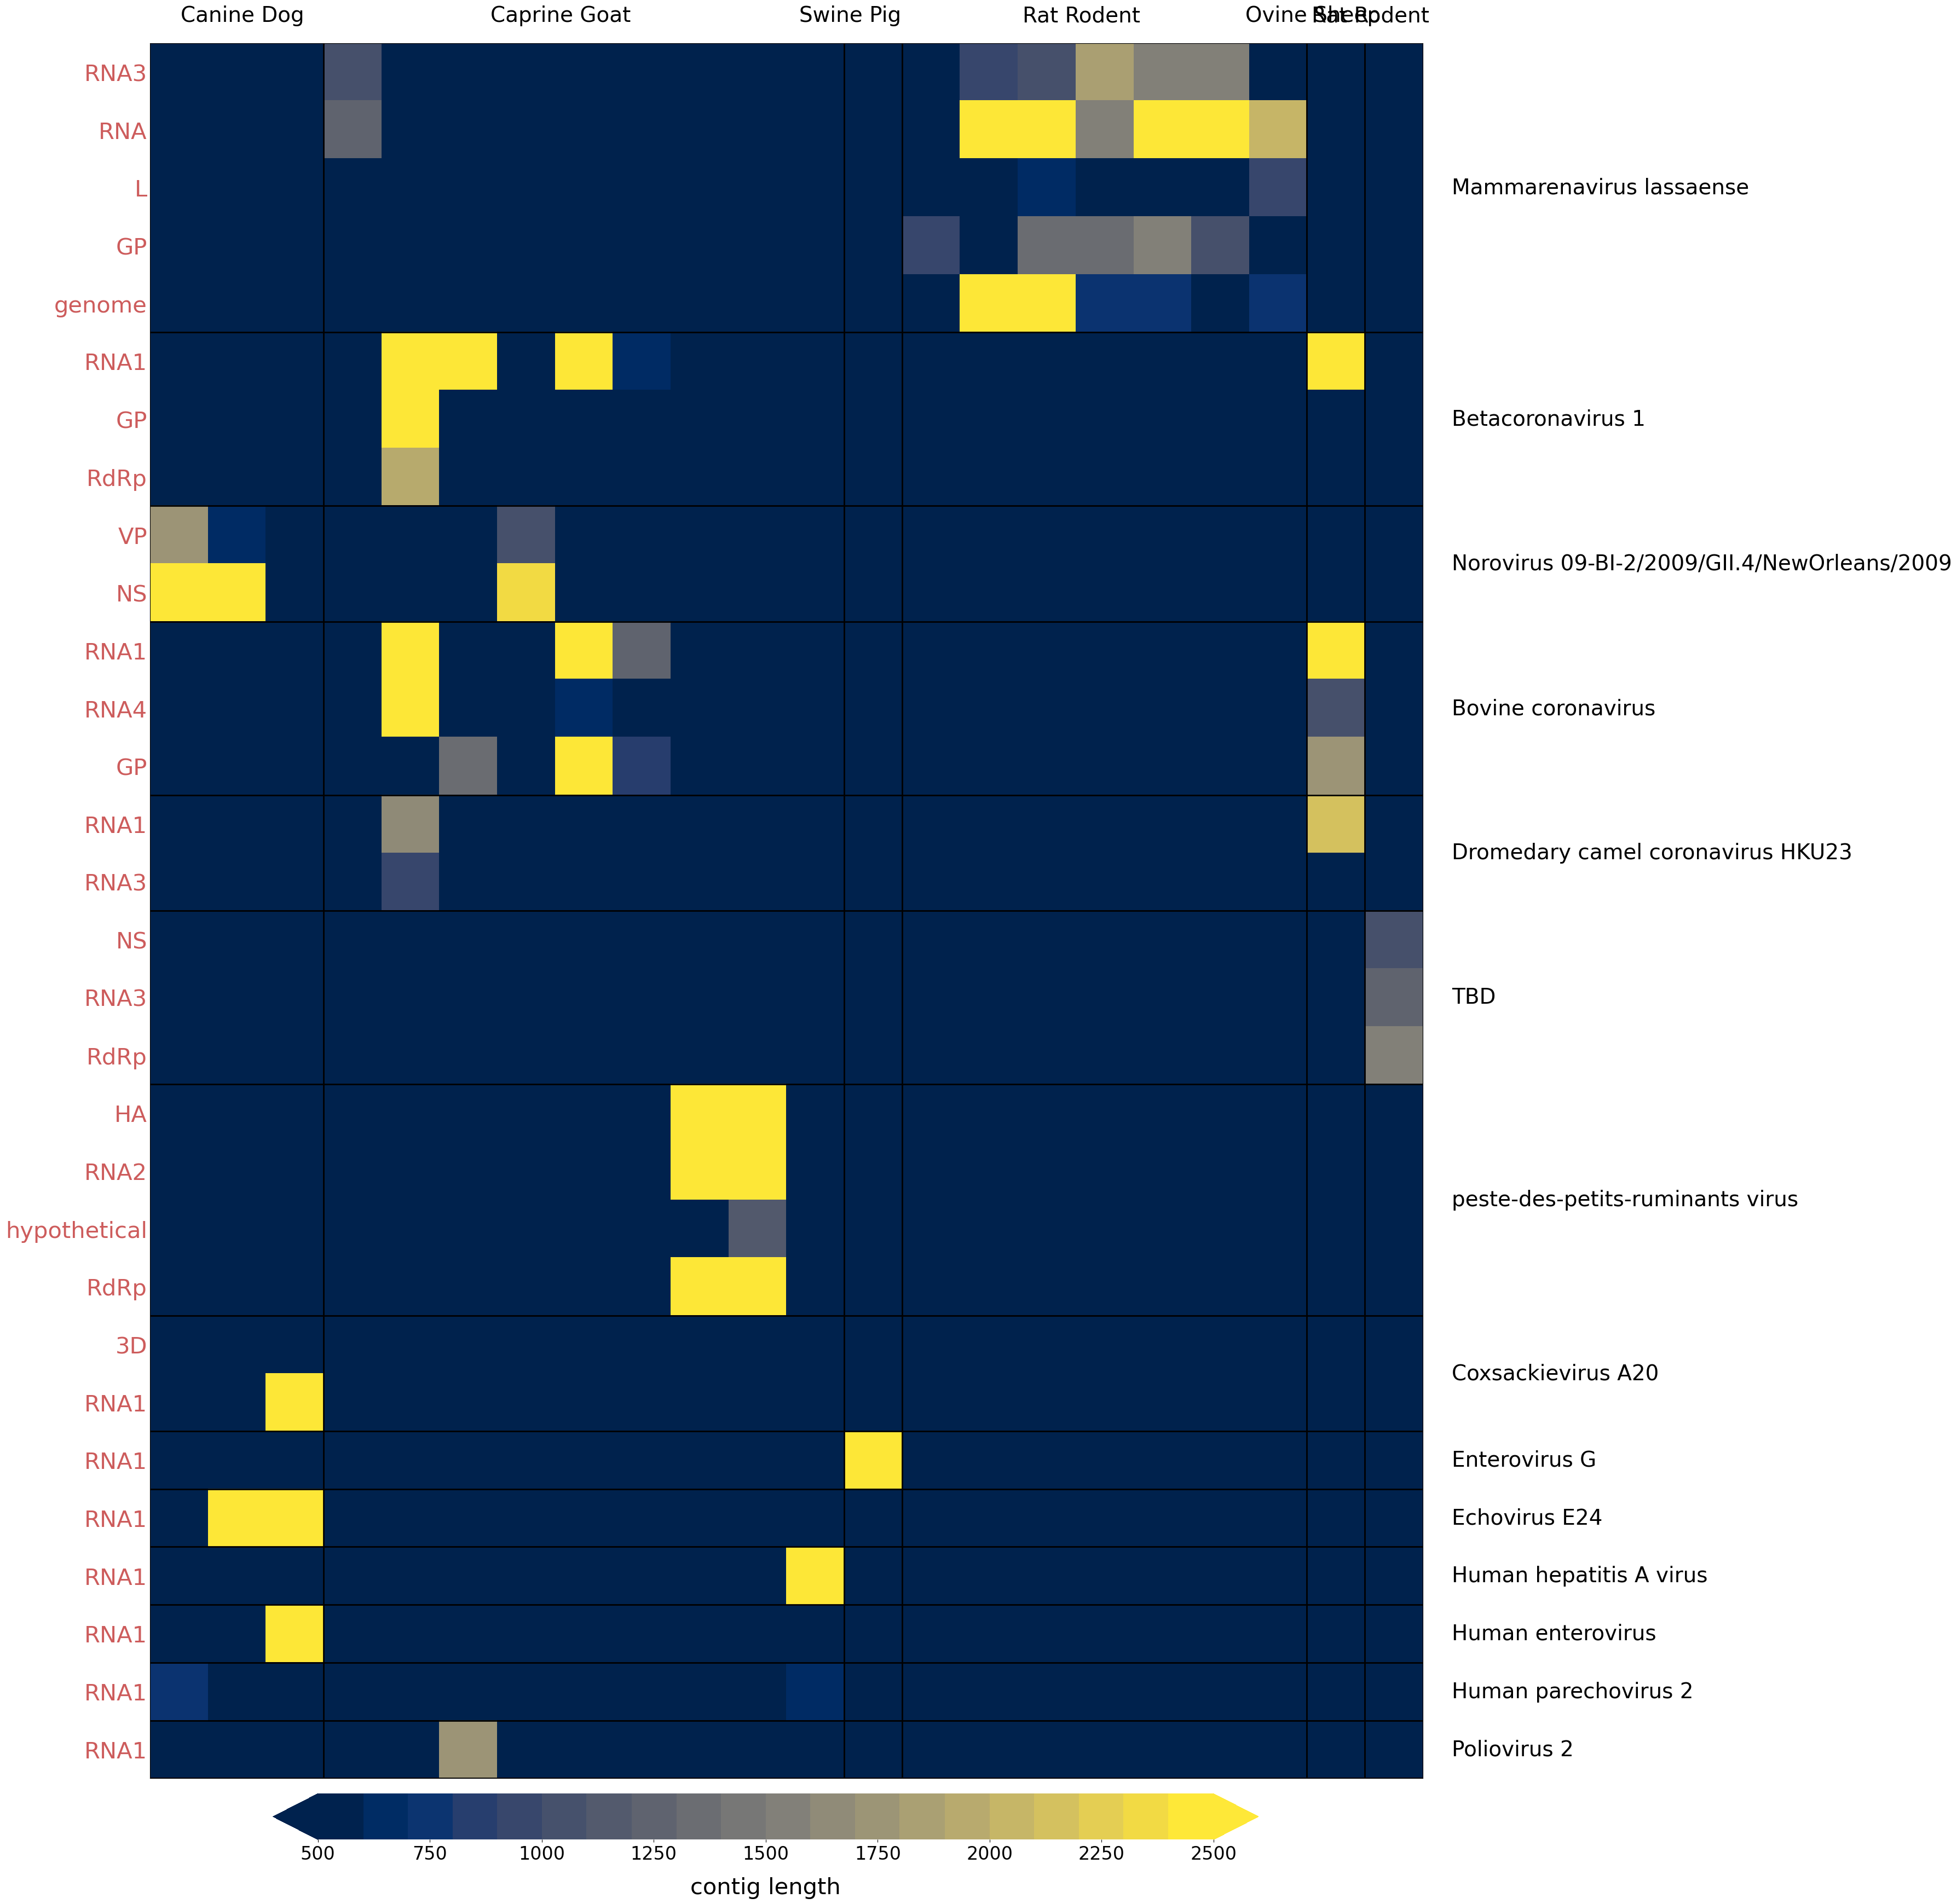

In [13]:
import textwrap

# subsetting=False ## showing all clusters
subsetting=True ## showing a subset of clusters (4 Orthomyxos + 1 Bunya)

showing='length'
# showing='reads'

sample_order=[]
for so in subset_order:
    for sa in virus[str(so)]['samples']:
        if sa not in sample_order:
            sample_order.append(sa)

if showing=='reads':
    matrix=rmatrix
#     norm=mpl.colors.LogNorm(vmin=1,vmax=1500000)
    norm=mpl.colors.LogNorm(vmin=100,vmax=7000000)
    extend='max'
elif showing=='length':
    matrix=lmatrix
    norm=mpl.colors.Normalize(vmin=500,vmax=2500)
    extend='both'

if subsetting==True:
    rows=sum(subset_row_names.values(),[])
    subset_species_order={'Cat': 0, 
                        'Canine Dog': 1, 
                        'Caprine Goat': 2,
                        "Sheep":4,
                        "Avian Chicken":5,
                        "Swine Pig":6,
                        "Bat Bat":7,
                        "Squirrel Squirrel":8,
                        "Cattle Egret":9,
                          "Rodent":10,
                          
                                               }


    matrix=matrix[rows].reindex(sorted(sample_order,key=lambda k: (subset_species_order[species(k)] if species(k) in subset_species_order else np.inf,sample_loc(k)!='WVAL'))).dropna(how='all') ## reindex only to Orthomyxos+Bunya, sort by species and location (in a way that gives good clusters), drop rows/columns that are all NaN
# else:
#     matrix=matrix.reindex(sorted(matrix.index,key=species))
    
if subsetting:
    base = 30  # Increased base size
else:
    base = 30

fig_width = base
fig_height = 1 + base * (matrix.shape[1] / matrix.shape[0])
fig = plt.figure(figsize=(fig_width, fig_height), facecolor='w') 
gs = gridspec.GridSpec(1, 1, wspace=0.7, hspace=0.5)  # Adjusted spacing

ax = plt.subplot(gs[0], facecolor='w')  # new subplot

def cmap_discretize(cmap, N):
    """Return a discrete colormap from the continuous colormap cmap.
    
        cmap: colormap instance, eg. cm.jet. 
        N: number of colors.
    """
    if type(cmap) == str:
        cmap = get_cmap(cmap)
    colors_i = np.concatenate((np.linspace(0, 1., N), (0.,0.,0.,0.)))
    colors_rgba = cmap(colors_i)
    indices = np.linspace(0, 1., N+1)
    cdict = {}
    for ki, key in enumerate(('red','green','blue')):
        cdict[key] = [(indices[i], colors_rgba[i-1,ki], colors_rgba[i,ki]) for i in range(N+1)]
    # Return colormap object.
    return mpl.colors.LinearSegmentedColormap(cmap.name + "_%d"%N, cdict, 1024)

cmap=cmap_discretize(mpl.cm.cividis,20)
ax.matshow(matrix.T,cmap=cmap,norm=norm,zorder=1)

ax.set_xticks(range(len(matrix.index)))
ax.set_yticks(range(len(matrix.columns)))

ax.set_xticklabels(matrix.index,rotation=90,size=12)
ax.set_yticklabels(matrix.columns, size=14)

for ticklabel in ax.get_yticklabels():
    if ticklabel.get_text() in did_not_blast:
        ticklabel.set_color('indianred')
        ticklabel.set_fontweight(500)
    else:
        pass

if subsetting==False:
    for t,ticklabel in enumerate(ax.get_xticklabels()):
        loc=sample_loc(ticklabel.get_text())
        if loc in sample_colour:
            colour=sample_colour[loc]
        else:
            colour='grey'
        
        ax.add_patch(plt.Rectangle((t-0.5,len(row_names)+0.8),1,1,
                                   facecolor=colour,edgecolor='none',zorder=100,clip_on=False))

modify_name=lambda k: ' '.join(k.get_text().split(' ')[1:-1])
virus_names=[modify_name(t) for t in ax.get_yticklabels()]
virus_coords={v: [i for i in range(len(virus_names)) if virus_names[i]==v] for v in set(virus_names)}

lw=2 if subsetting else 1
textsize=28 if subsetting else 14
for v in virus_coords:
    w=v
    if len(v)>10 and len(matrix)<50:
        w='\n'.join(textwrap.wrap(v,100))
    ax.text(len(matrix.index),np.mean(virus_coords[v]),w,size=textsize,rotation=0,va='center',ha='left')
    ax.axhline(max(virus_coords[v])+0.5,lw=lw,color='k') 
    

counter=0
for s in range(len(matrix.index)):
    if s==len(matrix.index)-1:
        if subsetting==True:
            ax.text(s-counter/2+0.1,-0.8,species(matrix.index[s]),size=28,rotation=0,va='bottom',ha='center')
            
    elif species(matrix.index[s])!=species(matrix.index[s+1]):
        if subsetting==True:
            ax.text(s-counter/2+0.1,-0.8,species(matrix.index[s]),size=28,rotation=0,va='bottom',ha='center')
        ax.axvline(s+0.5,lw=lw,color='k')
        counter=0
    
    counter+=1        

if subsetting:
    ax.set_xticklabels([])
    ax.set_yticklabels([label.get_text().split(' ')[0] for label in ax.get_yticklabels()],size=30)
else:
    ax.set_yticklabels([label.get_text().split(' ')[0] for label in ax.get_yticklabels()],size=22)
    ax.set_xticklabels(['%s (%s)'%(species(s),s) for s in sample_order])
    
ax.tick_params(size=0)

ax.vlines(np.arange(-0.5,len(matrix.index)-0.5,1.0),-0.5,len(matrix.columns)-0.5,color='lightgrey',lw=1,ls='--',zorder=0)

ax.xaxis.set_label_position('bottom')
ax.yaxis.set_label_position('right')

ax.set_xlim(-0.5,len(matrix.index)-0.5)
ax.set_ylim(len(matrix.columns)-0.5,-0.5)

axcb = fig.add_axes([0.2, 0.09, 0.6, 0.02], frame_on=False)
cb = mpl.colorbar.ColorbarBase(axcb,cmap=cmap,norm=norm,orientation='horizontal',extend=extend,alpha=1.0,drawedges=False)

axcb.tick_params(labelsize=24)
axcb.yaxis.set_label_position('right')
axcb.yaxis.tick_left()

if showing=='reads':
    axcb.set_xlabel('RPM',size=30)
elif showing=='length':
    axcb.set_xlabel('contig length',labelpad=18,size=30)

plt.savefig('/Volumes/aine_store/SENZOR_project/SPlited_SENSOR_porject/IDseq/Combined_SENZOR_results/fig5_co-occurrence_%s.png'%(showing),dpi=300,bbox_inches='tight')
plt.savefig('/Volumes/aine_store/SENZOR_project/SPlited_SENSOR_porject/IDseq/Combined_SENZOR_results/fig5_co-occurrence_%s.svg'%(showing),dpi=300,bbox_inches='tight')
plt.savefig('/Volumes/aine_store/SENZOR_project/SPlited_SENSOR_porject/IDseq/Combined_SENZOR_results/nfig5_co-occurrence_%s.pdf'%(showing),dpi=300,bbox_inches='tight')

out=open('/Volumes/aine_store/SENZOR_project/SPlited_SENSOR_porject/IDseq/Cluster_contigs/TableSX_Sensor-cooccurrence.tsv','w')
matrix.to_csv(out,sep='\t',float_format='%.f')
out.close()
plt.show()

In [1]:
%matplotlib inline
import matplotlib as mpl
from matplotlib import pyplot as plt
from matplotlib import gridspec

import matplotlib.patheffects as path_effects

import re,glob,os,json
import numpy as np
import pandas as pd

typeface='Helvetica Neue'
mpl.rcParams['axes.labelweight']=300
mpl.rcParams['font.family']=typeface
mpl.rcParams['font.size']=22

base_path='/Volumes/aine_store/SENZOR_project/SPlited_SENSOR_porject/IDseq/Cluster_contigs/'

from collections import defaultdict, namedtuple
Member = namedtuple('Member', ['contig', 'length', 'percent_id', 'percent_id_sign', 'sample', 'coverage'])

def parse_cdhit_row(row):
    if '*' in row:
        index, length, name, percent_id = row.split()
        percent_id_sign, percent_id = '0', 100
    else:
        index, length, name, _, percent_id = row.split()
    length = int(length.strip(',nt'))
    name = name.strip('>').strip('.')
    sample, contig = name.split('~')
    coverage = float(contig.split('_')[-1])
    
    if percent_id != 100:
        percent_id_sign, percent_id = percent_id.strip('%').split('/')
        percent_id = float(percent_id)
    return Member(contig=contig, sample=sample, length=length,
                  percent_id=percent_id, percent_id_sign=percent_id_sign, coverage=coverage)


clusters = defaultdict(list)
with open(os.path.join(base_path,'500_SENZOR_cluster.clstr'), 'r') as file:
    for line in file:
        if line.startswith('>Cluster'):
            cluster_id = line.split()[-1]
        else:
            member = parse_cdhit_row(line)
            if 'water' in member.sample.lower():
                continue
            clusters[cluster_id].append(member)
            

contig_info={}

for line in open(os.path.join(base_path, 'contig_calls1.tsv'), 'r'):
    l = line.strip('\n').split('\t')
    if l[0] == 'sample':
        header = {x: i for i, x in enumerate(l)}  # create header dict
    else:
        sample = l[header['sample']]
        contig_name = l[header['contig_name1']]
        read_count = int(float(l[header['read_count']]))  # Convert to int

        if sample not in contig_info:
            contig_info[sample] = {}

        # Build the contig_info dictionary with read_count as int
        contig_info[sample][contig_name] = {
            x: (int(float(l[header[x]])) if x == 'read_count' else l[header[x]])
            for x in header
        }


total_reads={}
for sample in contig_info:
    total_reads[sample]=0
    for contig in contig_info[sample]:
        blasted=True if contig_info[sample][contig]['blasted']=='True' else False
        curated=True if contig_info[sample][contig]['curated']=='True' else False
        read_count=int(contig_info[sample][contig]['read_count'])
#         print(contig,read_count,blasted,curated)
        total_reads[sample]+=read_count
    
print(sum(total_reads.values()))

in_json=open(os.path.join(base_path,'virus_data.json'),'r')
virus=json.load(in_json)

segmented_RdRps=[pol for pol in virus if len(virus[pol]['segments'])>0] ## all segmented viruses
# segmented_RdRps=virus.keys()
in_json.close()




58937201


In [48]:
import os
import json
from collections import defaultdict, namedtuple
import pandas as pd

# Define the namedtuple for Member
Member = namedtuple('Member', ['contig', 'length', 'percent_id', 'percent_id_sign', 'sample', 'coverage'])

# Define base path
base_path = '/Volumes/aine_store/SENZOR_project/SPlited_SENSOR_porject/IDseq/Cluster_contigs/'

# Function to parse CD-HIT cluster rows
def parse_cdhit_row(row):
    parts = row.strip().split()
    if '*' in row:
        index, length, name, percent_id = parts
        percent_id_sign, percent_id = '0', 100
    else:
        if len(parts) < 5:
            # Handle cases with missing percent_id
            index, length, name, _, percent_id = parts + ['0']
        else:
            index, length, name, _, percent_id = parts
        if '/' in percent_id:
            percent_id_sign, percent_id = percent_id.strip('%').split('/')
            percent_id = float(percent_id)
        else:
            percent_id_sign, percent_id = '0', 100
    try:
        length = int(length.strip(',nt'))
    except ValueError:
        length = 0  # Handle malformed length
    name = name.strip('>').strip('.').strip().lower()  # Standardize contig name
    try:
        sample, contig = name.split('~')
    except ValueError:
        # Handle cases where sample and contig are not separated by '~'
        sample, contig = 'UNKNOWN_SAMPLE', name
    try:
        coverage = float(contig.split('_')[-1])
    except (ValueError, IndexError):
        coverage = 0.0  # Handle malformed coverage
    return Member(contig=contig, sample=sample, length=length,
                  percent_id=percent_id, percent_id_sign=percent_id_sign, coverage=coverage)

# Build clusters dictionary
clusters = defaultdict(list)
cluster_file = os.path.join(base_path, '500_SENZOR_cluster.clstr')
with open(cluster_file, 'r') as file:
    for line in file:
        if line.startswith('>Cluster'):
            cluster_id = line.split()[-1]
        else:
            member = parse_cdhit_row(line)
            if 'water' in member.sample.lower():
                continue
            clusters[cluster_id].append(member)

# Build contig_info dictionary using pandas for robustness
contig_info = {}
contig_calls_file = os.path.join(base_path, 'contig_calls1.tsv')
try:
    contig_calls_df = pd.read_csv(contig_calls_file, sep='\t')
except Exception as e:
    print(f"Error reading {contig_calls_file}: {e}")
    exit(1)

# Standardize sample and contig names
contig_calls_df['sample'] = contig_calls_df['sample'].str.strip().str.upper()
contig_calls_df['contig_name'] = contig_calls_df['contig_name1'].str.strip().str.lower()

# Convert read_count to numeric, coercing errors to NaN and filling with 0
contig_calls_df['read_count'] = pd.to_numeric(contig_calls_df['read_count'], errors='coerce').fillna(0).astype(int)

# Build contig_info dictionary
for _, row in contig_calls_df.iterrows():
    sample = row['sample']
    contig_name = row['contig_name']
    read_count = row['read_count']
    
    if sample not in contig_info:
        contig_info[sample] = {}
    
    # Store all relevant fields
    contig_info[sample][contig_name] = row.to_dict()

# Calculate total_reads per sample
total_reads = {}
for sample in contig_info:
    # Sum read_count across all contigs in the sample
    total_reads[sample] = contig_calls_df[contig_calls_df['sample'] == sample]['read_count'].sum()

print(f"Total reads across all samples: {sum(total_reads.values())}")

# Diagnostic: Inspect read_count for a few samples and contigs
print("\n--- Diagnostic: Sample Contig Read Counts ---")
for sample in list(contig_info.keys())[:3]:  # Inspect first 3 samples
    for contig in list(contig_info[sample].keys())[:3]:  # Inspect first 3 contigs per sample
        read_count = contig_info[sample][contig].get('read_count', 0)
        print(f"Sample: {sample}, Contig: {contig}, Read Count: {read_count}")

# Load virus data
virus_data_file = os.path.join(base_path, 'virus_data.json')
try:
    with open(virus_data_file, 'r') as in_json:
        virus = json.load(in_json)
except Exception as e:
    print(f"Error reading {virus_data_file}: {e}")
    exit(1)

# Identify segmented viruses
segmented_RdRps = [pol for pol in virus if len(virus[pol].get('segments', {})) > 0]
print(f"Total segmented RdRps: {len(segmented_RdRps)}")

# Load metadata
metadata = {}
metadata_file = os.path.join(base_path, 'Metada_annotated.csv')
try:
    metadata_df = pd.read_csv(metadata_file)
except Exception as e:
    print(f"Error reading {metadata_file}: {e}")
    exit(1)

# Build metadata dictionary
for _, row in metadata_df.iterrows():
    sample_id = row['NewIDseqName']
    metadata[sample_id] = row.to_dict()

# Define helper functions
def species(sample):
    return f"{metadata.get(sample, {}).get('ska_genus', 'Unknown')} {metadata.get(sample, {}).get('ska_species', 'Unknown')}"

def sample_loc(sample):
    return metadata.get(sample, {}).get('collected_by', 'Unknown')

# Define order and sorting functions
order = [
    'DNA_pol', 'pol', 'RdRp_RNA1', 'RdRp_RNA', 'RdRp_VP', 
    'RdRp_VP1', 'NSP', 'gag', 'NP', 'GP', 'hypothetical'
]
print("Order list:", order)

def sort_RdRps(k):
    return (virus[k].get('family', ''), -len(clusters.get(k, [])))

def sort_segs(k):
    if k in order:
        return (0, -order.index(k), k)
    else:
        return (1, k, k)

subset_order = [242, 34, 207, 71, 159, 164]
subset_row_names = {pol: [] for pol in subset_order}

# Initialize matrices and tracking lists
read_matrix = {}
length_matrix = {}
sample_order_list = []
row_names = []
did_not_blast = []

# Diagnostic: List of all samples in contig_info
print(f"\nTotal samples in contig_info: {len(contig_info)}")
for sample in list(contig_info.keys())[:5]:  # Display first 5 samples
    print(f"Sample: {sample}, Number of contigs: {len(contig_info[sample])}")
    for contig in list(contig_info[sample].keys())[:5]:
        print(f"  Contig: {contig}")

# Process each segmented RdRp
for p, pol in enumerate(sorted(segmented_RdRps, key=sort_RdRps), 1):
    print(f"\nProcessing RdRp {p}/{len(segmented_RdRps)}: {pol}")
    family = virus[pol].get('family', 'Unknown')
    name = virus[pol].get('provisional_name', virus[pol].get('name', 'Unknown'))
    samples = virus[pol].get('samples', [])
    
    print(f"  Family: {family}, Name: {name}")
    
    # Standardize sample names when adding to sample_order
    for sample in sorted(samples, key=lambda k: (sample_loc(k), species(k), -total_reads.get(k, 0))):
        standardized_sample = sample.strip().upper()
        if standardized_sample not in sample_order_list:
            sample_order_list.append(standardized_sample)
            print(f"  Added sample to order: {standardized_sample}")
            
            # Initialize the new sample in all existing rows
            for row in read_matrix:
                read_matrix[row][standardized_sample] = 0
                length_matrix[row][standardized_sample] = 0
    
    for seg in sorted(virus[pol].get('segments', {}), key=sort_segs):
        print(f"  Processing segment: {seg}")
        segment_clusters = list(map(str, virus[pol]['segments'][seg].get('clusters', [])))
        s = seg.split('_')[1] if 'RdRp' in seg else seg
    
        row_name = f"{s} {name} ({family.replace('viridae', '').strip()})"
        row_names.append(row_name)
        if int(pol) in subset_row_names:
            subset_row_names[int(pol)].append(row_name)
    
        if row_name not in read_matrix:
            # Initialize all samples with 0
            read_matrix[row_name] = {sample: 0 for sample in sample_order_list}
            length_matrix[row_name] = {sample: 0 for sample in sample_order_list}
            print(f"    Initialized matrices for row: {row_name}")
    
        B = []  # Track whether contigs have blasted
        for clust in segment_clusters:
            print(f"    Processing cluster: {clust}")
            members = clusters.get(clust, [])
            print(f"      Number of members in cluster: {len(members)}")
            for m in members:
                # Standardize sample and contig names
                standardized_sample = m.sample.strip().upper()
                standardized_contig = m.contig.strip().lower()
    
                # Check if the sample is already in sample_order_list
                if standardized_sample not in sample_order_list:
                    sample_order_list.append(standardized_sample)
                    print(f"    Added sample to order: {standardized_sample}")
                    
                    # Initialize the new sample in all existing rows
                    for row in read_matrix:
                        read_matrix[row][standardized_sample] = 0
                        length_matrix[row][standardized_sample] = 0
    
                # Proceed only if the sample exists in contig_info
                if standardized_sample in contig_info:
                    if standardized_contig in contig_info[standardized_sample]:
                        # Process contig
                        blasted = contig_info[standardized_sample][standardized_contig].get('blasted', 'False') == 'True'
                        B.append(blasted)
                        length_matrix[row_name][standardized_sample] += m.length
                        read_count = contig_info[standardized_sample][standardized_contig].get('read_count', 0)
    
                        # Prevent division by zero and scale to RPM
                        if total_reads.get(standardized_sample, 0) > 0:
                            read_fraction = (int(read_count) / total_reads[standardized_sample]) * 1e6  # RPM scaling
                        else:
                            read_fraction = 0
                            print(f"    Warning: Total reads for sample '{standardized_sample}' is zero. RPM set to 0.")
                        read_matrix[row_name][standardized_sample] += read_fraction
                        
                        # Diagnostic print
                        print(f"        Sample: {standardized_sample}, Read Count: {read_count}, Total Reads: {total_reads[standardized_sample]}, RPM: {read_fraction}")
                    else:
                        print(f"        Contig '{standardized_contig}' not found in contig_info for sample '{standardized_sample}'")
                else:
                    print(f"        Sample '{standardized_sample}' not found in contig_info")
        
        if B:
            if B.count(False) > len(B) / 2:
                did_not_blast.append(row_name)
                print(f"    More than half contigs did not blast for row: {row_name}")
        else:
            print(f"    No contigs processed for row: {row_name}")

# Diagnostic: Check for samples with zero total reads
zero_total_reads = [sample for sample, reads in total_reads.items() if reads == 0]
if zero_total_reads:
    print(f"\nWarning: The following samples have zero total reads and will have RPM set to 0:")
    for sample in zero_total_reads:
        print(f"  - {sample}")
else:
    print("\nAll samples have non-zero total reads.")

# Convert to pandas DataFrames
rmatrix = pd.DataFrame(read_matrix, index=sample_order_list)
lmatrix = pd.DataFrame(length_matrix, index=sample_order_list)

# Fill NaN values with 0 to prevent issues in analysis
rmatrix = rmatrix.fillna(0)
lmatrix = lmatrix.fillna(0)

# Display RPM min and max
rpm_min = rmatrix.min().min() if not rmatrix.empty else None
rpm_max = rmatrix.max().max() if not rmatrix.empty else None
print(f"\nRPM minmax: {rpm_min} {rpm_max}")

# Diagnostic: Verify RPM Calculations
print("\n--- Diagnostic: Verify RPM Calculations ---")
for sample in list(rmatrix.index)[:3]:  # Inspect first 3 samples
    for row in rmatrix.columns[:3]:  # Inspect first 3 rows per sample
        rpm_value = rmatrix.loc[sample, row]
        print(f"Sample: {sample}, Row: {row}, RPM: {rpm_value}")

# Optional: Display a subset of the matrices for verification
print("\nSample of RPM matrix:")
print(rmatrix.head())

print("\nSample of Length matrix:")
print(lmatrix.head())


/var/folders/xt/vz8fznds4hdbfcxyds95mtp00000gp/T/ipykernel_9225/2009760998.py:63: DtypeWarning: Columns (4,15,18) have mixed types. Specify dtype option on import or set low_memory=False.
  contig_calls_df = pd.read_csv(contig_calls_file, sep='\t')


Total reads across all samples: 60738576

--- Diagnostic: Sample Contig Read Counts ---
Sample: AIAMAAGR001_LIV_S46_662105, Contig: node_272_length_833_cov_1.764550, Read Count: 31
Sample: AIAMAAGR001_LIV_S46_662105, Contig: node_298_length_799_cov_1.400277, Read Count: 20
Sample: AIAMAAGR001_LIV_S46_662105, Contig: node_384_length_689_cov_9.700980, Read Count: 122
Sample: AIAMACAT001_S69_657769, Contig: node_124_length_1123_cov_7.085086, Read Count: 162
Sample: AIAMACAT001_S69_657769, Contig: node_134_length_1069_cov_8.698589, Read Count: 194
Sample: AIAMACAT001_S69_657769, Contig: node_173_length_926_cov_99.355713, Read Count: 2154
Sample: AIAMADOG001_S40_657732, Contig: node_1261_length_596_cov_1.558767, Read Count: 19
Sample: AIAMADOG001_S40_657732, Contig: node_1503_length_558_cov_1.800416, Read Count: 15
Sample: AIAMADOG001_S40_657732, Contig: node_1614_length_544_cov_1.466809, Read Count: 13
Total segmented RdRps: 329
Order list: ['DNA_pol', 'pol', 'RdRp_RNA1', 'RdRp_RNA', 'RdRp